In [1]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
import scipy.fftpack as sff

**I - Data generation and manipulation**

The objective of this first short part is to create some datasets to get accustomed to them. It will enable us to :
- recall the notion of sparsity ;
- geometrically understand the effect of the mixing.

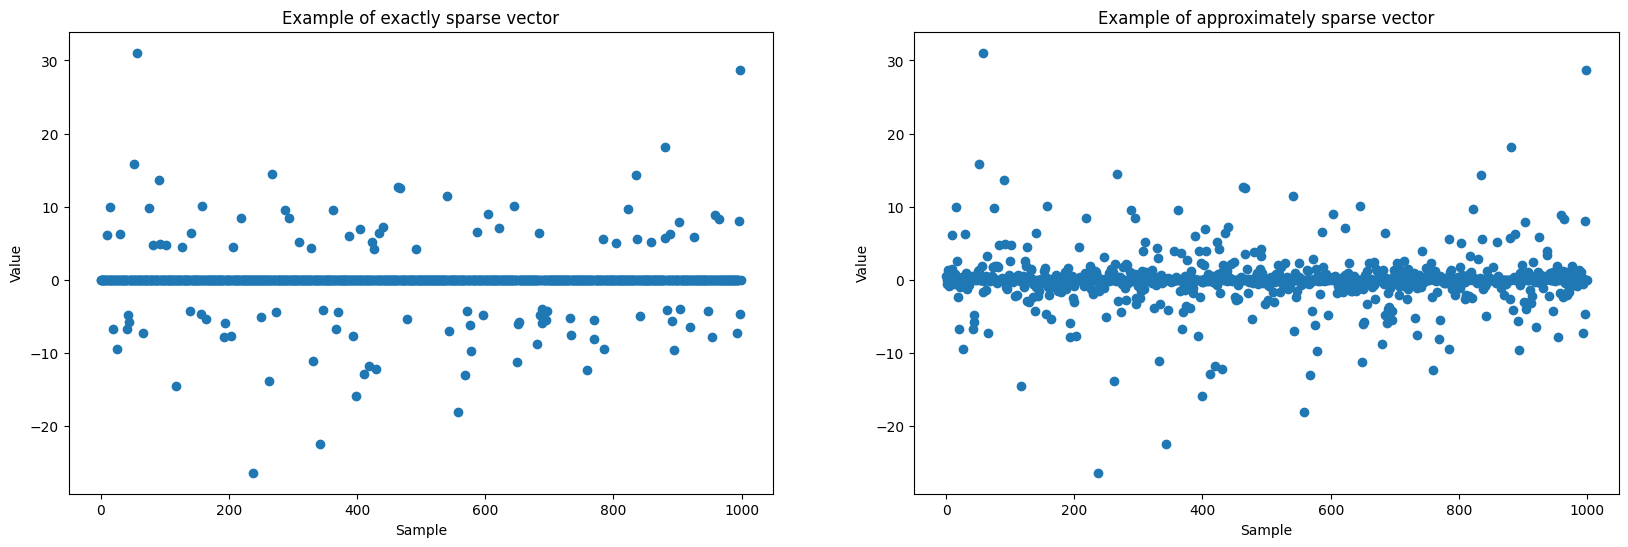

In [2]:
power = 3
approx_sparse = np.random.randn(1000)**power
exact_sparse = approx_sparse*(np.abs(approx_sparse)>4)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.plot(exact_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of exactly sparse vector');

fig.add_subplot(1,2,2)
plt.plot(approx_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of approximately sparse vector');

What is the difference between an exactly and an approximately sparse signal? Recall the two corresponding definitions.

### **Exactly Sparse Signal**:
   An exactly sparse signal is one in which only a small number of the signal’s elements (or coefficients, when transformed into another basis such as Fourier or wavelet) are non-zero. The rest of the elements are exactly zero. This means that in an exactly sparse signal, the majority of the data points do not carry significant information, allowing for data compression and simplified processing without loss of crucial information.

   - **Definition**: A signal $x \in \mathbb{R}^n$ is said to be $k$-sparse in a dictionary $D$ (where $D$ is a matrix whose columns form a basis or a frame) if it can be expressed as $x = D\alpha$ where the coefficient vector $\alpha$ contains at most $k$ non-zero elements.

### **Approximately Sparse Signal**:
   An approximately sparse signal is one where the signal’s elements decay to zero rapidly, meaning that while not all non-significant elements are exactly zero, they are close enough to zero that setting them to zero would cause minimal error. This approximation allows for practical sparsity where signals are not perfectly sparse but can be treated as such with negligible loss of fidelity.

   - **Definition**: A signal $x \in \mathbb{R}^n$ is approximately $k$-sparse in a dictionary $D$ if it can be well-approximated by a $k$-sparse signal. Specifically, if $x = D\alpha$ and the sorted magnitudes of the coefficients $\alpha$ (from largest to smallest) decay quickly, the signal is approximately sparse. The approximation quality might be quantified by saying the error $\|x - D\alpha_k\|$ is small, where $\alpha_k$ is the best $k$-sparse approximation to $\alpha$.

Now let's start to look at some mixtures and to try to geometrically interpret the impact of the mixing.

First, generate a simulated source S matrix. Plot the corresponding scatter plot. Interpret the shape of the scatter plot you obtain.

In [3]:
n = 2         # number of sources
t = 1024      # number of samples
noise_level = 80 # noise level, in dB
power = 3 # power exponent used in the source generation

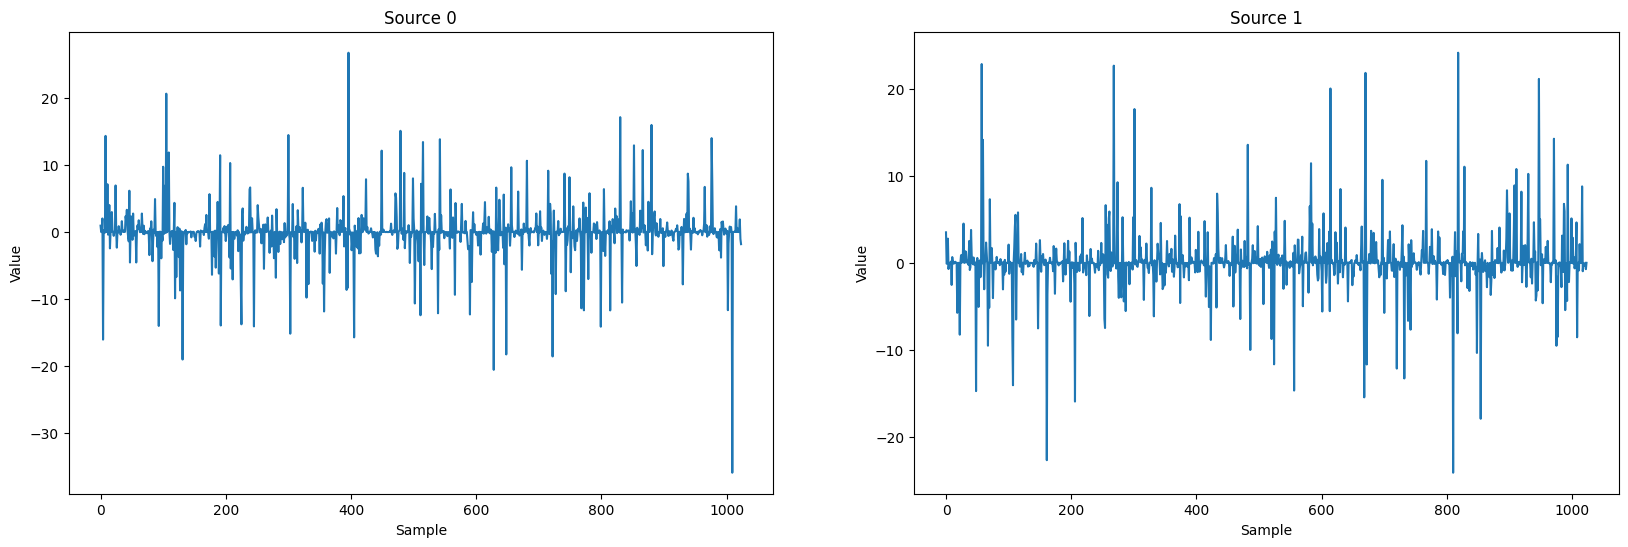

In [4]:
# TO DO : generate a simulated source S matrix.
# S will be of dimensions n x t.
# Each of the n sources (i.e. lines of S) will follow the approximately sparse
# law we used above.

S = np.random.randn(n, t)**power

# Plot the sources
fig = plt.figure(figsize=(20, 6))
for i in range(n):
    fig.add_subplot(1,n,i+1)
    plt.plot(S[i,:])
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.title('Source %d' % i)

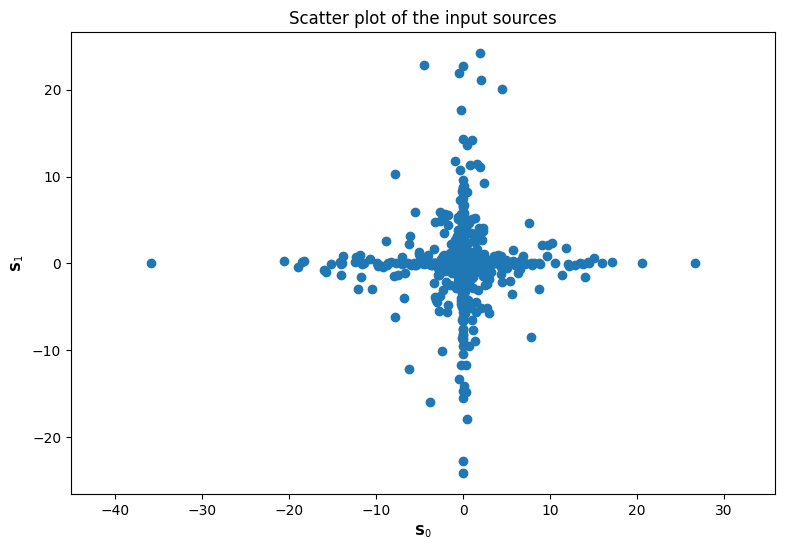

In [5]:
fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

The scatter plot of the simulated source $S$ matrix reveals a distinct star-shaped pattern, characterized by data points radiating from a central core along multiple axes. This configuration suggests that the data might be influenced by power-law distributions, where deviations from the center vary in a structured manner along specific directions. Such a pattern often indicates underlying variables that interact multiplicatively, common in phenomena where certain measurements increase or decrease dramatically relative to a central point. This kind of distribution is useful for analyzing scenarios with non-uniform, scale-invariant behavior, often seen in natural and social systems.

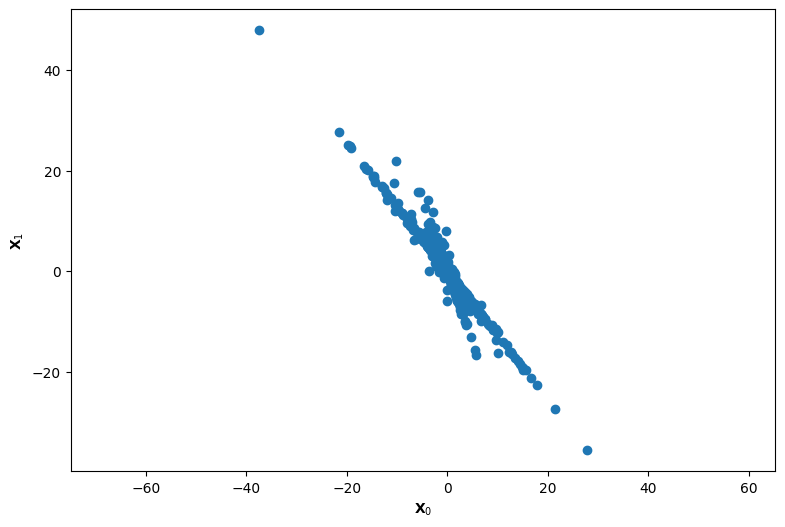

In [6]:
# Here, we generate a mixture matrix (dimensions m x t) from the sources in S
m = 4         # number of observations

A = np.random.randn(m,n)
X = A@S

noise_level = 120

# To be more realistic, we add some noise to the mixing.
# Mixtures with SNR > 120 dB can be considered as noiseless for most applications.
if noise_level < 120:
    #--- Add noise
    N = np.random.randn(m,t)
    N = 10.**(-noise_level/20.)*np.linalg.norm(X)/np.linalg.norm(N)*N
    X = X + N

# Scatter plot of X, figure per iteration}
fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.plot(X[0, :], X[1, :], 'C0o')
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis('equal');


Plot the scatter plot of X. What do you see ?

What do the directions of the lines you observe correspond ?

Try several A matrices, noise_values and powers. Any comment?

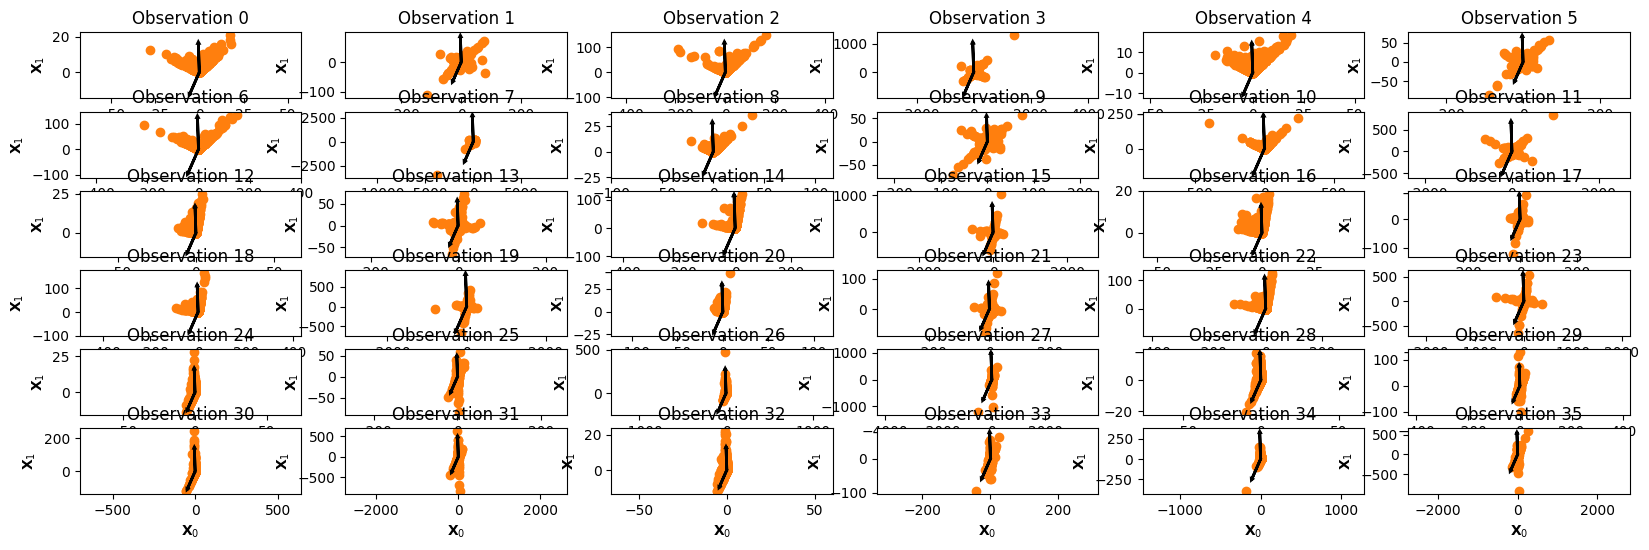

In [7]:
# Generating different mixing matrices
matrices_A = []
for i in range(3):
    A = np.random.randn(m,n)
    matrices_A.append(A)

# Generating different noise levels
noise_levels = [80, 100, 120]

# Generating different power exponents
power_exponents = [2, 3, 4, 5]

# Generating obvervations X for each combination of A, noise level and power exponent
observations = []
for A in matrices_A:
    for noise_level in noise_levels:
        for power in power_exponents:
            S = np.random.randn(n, t)**power
            X = A@S
            if noise_level < 120:
                #--- Add noise
                N = np.random.randn(m,t)
                N = 10.**(-noise_level/20.)*np.linalg.norm(X)/np.linalg.norm(N)*N
                X = X + N
            observations.append(X)

fig = plt.figure(figsize=(20, 6))
for i, X in enumerate(observations):
    plt.subplot(6,6,i+1)
    vrange = 0.25*max(np.sqrt(np.sum(X*X, 0)))
    plt.arrow( 0, 0, vrange*A[0, 0], vrange*A[1, 0], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
    plt.arrow( 0, 0, vrange*A[0, 1], vrange*A[1, 1], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
    plt.plot(X[0, :], X[1, :], 'C1o', zorder=0)
    plt.xlabel("$\mathbf{X}_0$")
    plt.ylabel("$\mathbf{X}_1$")
    plt.axis('equal')
    plt.title('Observation %d' % i)

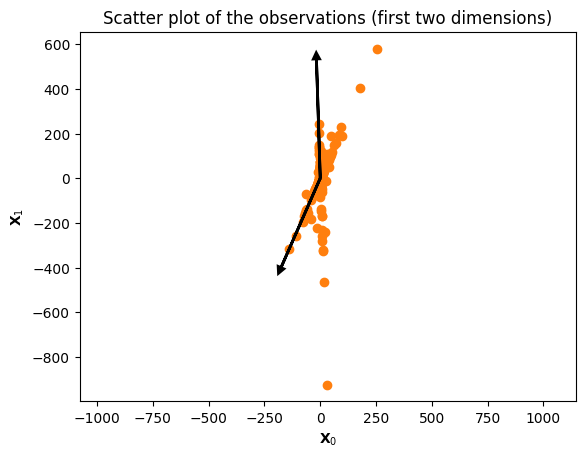

In [8]:
plt.title('Scatter plot of the observations (first two dimensions)')
vrange = 0.25*max(np.sqrt(np.sum(X*X, 0)))
plt.arrow( 0, 0, vrange*A[0, 0], vrange*A[1, 0], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.arrow( 0, 0, vrange*A[0, 1], vrange*A[1, 1], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.plot(X[0,:], X[1,:], 'C1o', zorder=0)
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis('equal');

1. **Linear Transformations Represented by A Matrices**: The directions of the lines in each subplot likely represent the influence of different linear transformations applied to the data, defined by different $A$ matrices. Each $A$ matrix applies a specific transformation to the input data, changing the orientation, spread, and even the scale of the data points along these lines.

2. **Impact of Noise**: The scatter of data points around the lines suggests the addition of noise. Variations in the `noise_values` parameter explain the differing degrees of dispersion around these lines across observations. Noise can affect the clarity of the linear relationship, making it harder to visually assess the exact relationship and the effectiveness of the transformation.

3. **Power Variations**: Changing the `power` parameter likely affects how the data is scaled or transformed before being subjected to the linear transformation $A$. This could explain why some plots show more extreme variations and scaling effects than others. Higher powers might amplify differences in data scaling, leading to more pronounced effects under the same transformation.

4. **Scale and Shift Variations**: The x and y-axes across the plots show different scales, indicating that each observation might involve not only different transformations and noise levels but potentially different scaling and shifting of the data points themselves. This can be a result of how the $A$ matrix and power parameters are being applied.

**II - Performing non-blind source separation**

**1) Data generation**

Before going into blind source separation, in which we want to find physical **A** and **S** matrices such that **X = AS + N**, let us first consider the simpler setting in which we know **A** and want to recover **S**.
We will consider the noisy mixture of two sine signals. The methodology extends to more complex datasets.

N.B. : unmixing two sinus signal could be done much more easily than using the algorithms we saw during the class. Nevertheless, focusing on such synthetic data enables an easy visualization. The principle readily extend to more complex datasets, such as images.

(-25.0, 25.0)

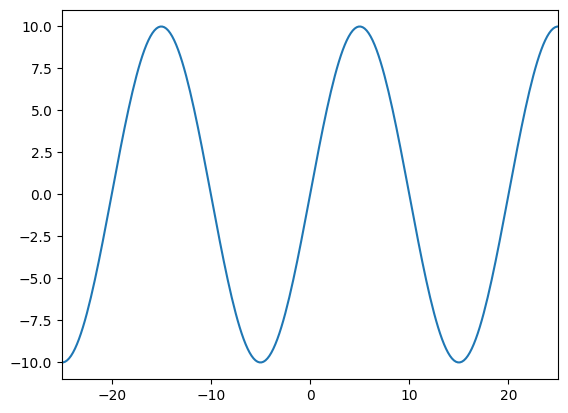

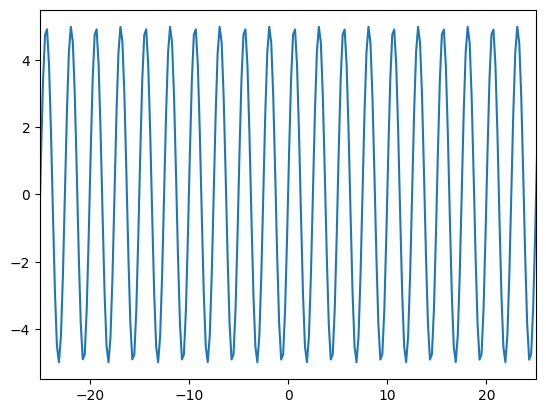

In [9]:
# Source generation
t = 10000
x_abs = np.linspace(-1000,1000,t)

S = np.zeros((2,t))
S[0,:] = 10*np.sin(2*np.pi*0.05*x_abs)
S[1,:] = 5*np.sin(2*np.pi*0.4*x_abs)

plt.figure(),plt.plot(x_abs,S[0,:])
plt.xlim([-25,25])
plt.figure(),plt.plot(x_abs,S[1,:])
plt.xlim([-25,25])

Here, we will transform the sources signals S into the DCT domain.

What is the objective of using the DCT?

Plot the above DCT and justify what you see. Pay attention to the labeling of the x-axis. Try with sines of various frequencies.

(<Figure size 640x480 with 1 Axes>,
 [<matplotlib.lines.Line2D at 0x1ed685fee50>])

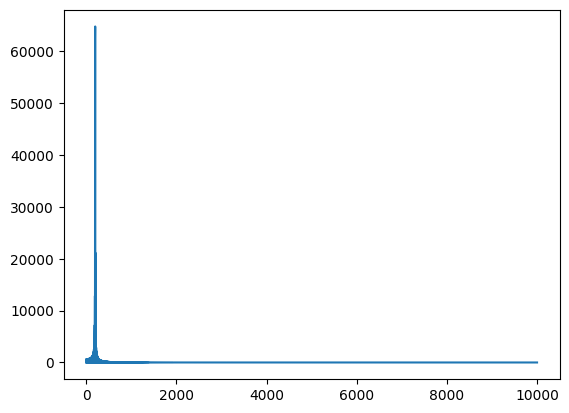

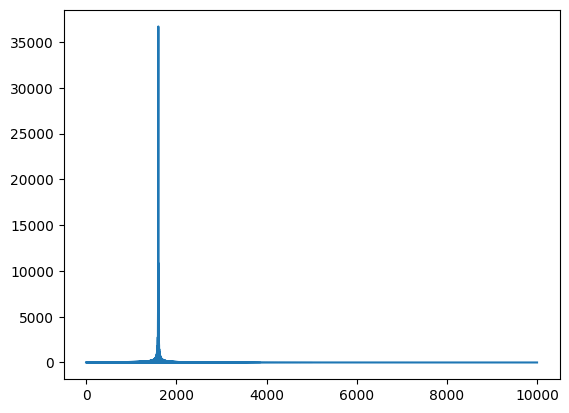

In [10]:
# Transformation into the DCT domain
Sf = sff.dct(S)

plt.figure(),plt.plot(abs(Sf[0,:]))
plt.figure(),plt.plot(abs(Sf[1,:]))

(<Figure size 640x480 with 1 Axes>,
 [<matplotlib.lines.Line2D at 0x1ed688f1b10>])

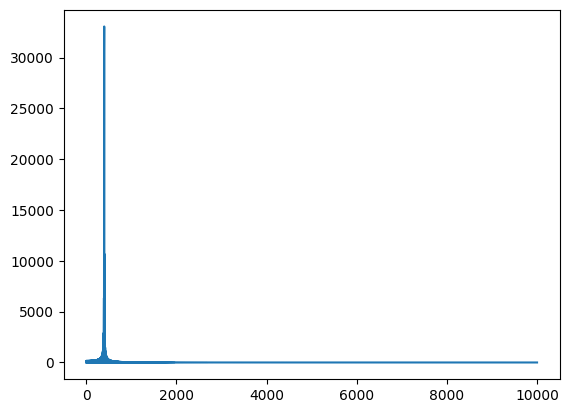

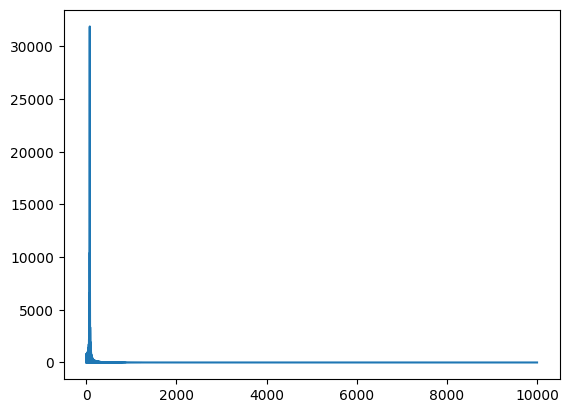

In [11]:
S[0,:] = 5*np.sin(2*np.pi*0.1*x_abs)
S[1,:] = 5*np.sin(2*np.pi*0.02*x_abs)

# Transformation into the DCT domain
Sf = sff.dct(S)

plt.figure(),plt.plot(abs(Sf[0,:]))
plt.figure(),plt.plot(abs(Sf[1,:]))

The Discrete Cosine Transform (DCT) is widely used in signal and image processing for several key reasons.

One of the primary advantages of the DCT is its ability to compact energy into a small number of coefficients for signals or images that are highly correlated. This means that significant information of the original signal is concentrated in just a few DCT coefficients. This characteristic is particularly useful for compression purposes, as it allows for the storage or transmission of a reduced amount of data while retaining the essential information of the original signal.

The DCT helps in removing redundancy between the pixels or signal elements. By converting the signal into a form where the coefficients are less correlated than in the spatial (or time) domain, it makes the signal more suitable for further compression techniques like quantization in image compression (e.g., JPEG).

In the DCT domain, it becomes easier to analyze the signal for features that might not be as obvious in the time domain. For instance, periodicities and certain types of patterns can be more readily analyzed and identified in the DCT domain.

Most energy of the transformed signals is concentrated in the first few coefficients. This observation is reflected by the spikes at the beginning of the plots, with the rest of the coefficients towards the right having significantly lower magnitudes:

The pronounced spikes at the low-frequency endsuggest that the signals are highly correlated or have a smooth structure in the time/space domain. DCT efficiently packs the energy of such signals into fewer coefficients. 

Typically, DCT coefficients are plotted starting from zero up to $N-1$ where $N$ is the number of coefficients, reflecting increasing frequency components. Each point on the x-axis corresponds to a specific frequency component of the DCT, where the leftmost represents the lowest frequency (DC component).

The observed rapid decay in the magnitude of the coefficients indicates that the signals are good candidates for compression. By zeroing out the smaller coefficients, which likely contribute little to the overall signal, you can achieve significant data reduction with minimal loss in reconstruction quality.

Data generation : now, we will create a mixture X = AS + N.

Plot the mixtures. Explain what you see.

Compute the DCT of X. Plot it and explain. Which caracteristic of the DCT will we use to recover the sources?

In [12]:
S = np.zeros((2,t))
S[0,:] = 10*np.sin(2*np.pi*0.05*x_abs)
S[1,:] = 5*np.sin(2*np.pi*0.4*x_abs)

(<Figure size 640x480 with 1 Axes>,
 [<matplotlib.lines.Line2D at 0x1ed689bf510>])

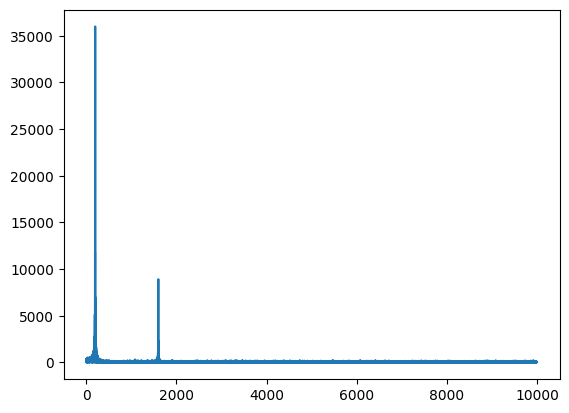

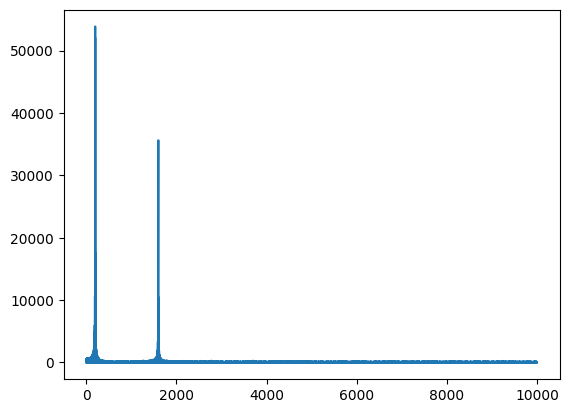

In [13]:
A = np.array([[0.5547002 , 0.24253563],
       [0.83205029, 0.9701425 ]]) # You can try other A values, but the columns must have a unitary norm.

X = A@S
X = X + 0.5*np.random.randn(np.shape(X)[0],np.shape(X)[1])# You can try other noise values

# Transformation into the DCT domain
Xf = sff.dct(X)

plt.figure(),plt.plot(abs(Xf[0,:]))
plt.figure(),plt.plot(abs(Xf[1,:]))


**2) Source separation**

Now that we generated observations from simulated sources, we will focus on the source separation problem: recovering the sources from the observations (and the knowledge of A, since we are here in the non-blind setting).

To do that, we propose here to solve the source separation problem using a sparsity constraint on the sources. The cost function will then be minimized using the ISTA algorithm.

First, write the cost function we want to minimize to perform non-blind sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?

To solve the non-blind sparse source separation problem using a sparsity constraint, a cost function is typically formulate that integrates both fidelity to the observed data and promotes sparsity in the sources. The typical cost function can be expressed as:

$J(S) = \frac{1}{2} \| X - AS \|_F^2 + \lambda \| S \|_1$

Where:
- $X$ is the matrix of observed data.
- $A$ is the known mixing matrix.
- $S$ is the matrix of sources we aim to recover.
- $\| \cdot \|_F$ denotes the Frobenius norm, which is used here to measure the fit between the observed data and the model predictions $AS$. This term ensures that the reconstructed signals $AS$ are close to the actual observed signals $X$.
- $\| \cdot \|_1$ denotes the $L1$ norm, which is a common sparsity-inducing norm. The $L1$ norm is used to enforce the sparsity of the source signals $S$.
- $\lambda$ is a regularization parameter that controls the trade-off between the fidelity of the reconstruction and the sparsity of the sources. A higher value of $\lambda$ places more emphasis on sparsity, potentially at the expense of fitting the observed data less closely.

**Explanation of Each Term:**

1. **Smooth Term - $\frac{1}{2} \| X - AS \|_F^2$**: This term is smooth with respect to $S$ because its gradient with respect to $S$ can be computed in a closed form. It is a quadratic function, which is generally smooth and differentiable everywhere. This term ensures that the solution respects the structure and nature of the observed data.

2. **Non-Smooth Term - $\lambda \| S \|_1$**: The $L1$ norm is non-smooth due to its absolute value, which introduces a kink at zero. This non-smoothness is what promotes sparsity; the absolute value function penalizes non-zero entries linearly, encouraging solutions where many entries in $S$ are exactly zero.

**Convexity of the Cost Function:**

The cost function $J(S)$ is convex. This is because the sum of two convex functions is also convex:

- The first term $\frac{1}{2} \| X - AS \|_F^2$ is convex in $S$ as it is a quadratic function of $S$.
- The second term $\lambda \| S \|_1$ is a norm, and all norms are convex functions.

Since both terms are convex and the sum of convex functions remains convex, the entire cost function $J(S)$ is convex. This convexity is advantageous because it guarantees that any local minimum found by an optimization algorithm is also a global minimum, simplifying the optimization process.

Compute the gradient along the S variable of the data-fidelity term.

The data-fidelity term in the cost function for the non-blind sparse source separation problem is given by:

$$\frac{1}{2} \| X - AS \|_F^2$$

This part of the cost function measures how well the mixed sources $AS$ approximate the observed data $X$. 

1. **Frobenius Norm**: The Frobenius norm of a matrix $M$ is defined as:

   $$\| M \|_F = \sqrt{\sum_{i,j} M_{ij}^2}$$

   For the function $f(S) = \frac{1}{2} \| X - AS \|_F^2$, the squared Frobenius norm simplifies to:

   $f(S) = \frac{1}{2} \text{tr}((X - AS)^\top (X - AS))$
   where $\text{tr}$ denotes the trace of a matrix.

2. **Expand and Simplify**:
   
   $$f(S) = \frac{1}{2} \text{tr}((X - AS)^\top (X - AS))$$
   $$= \frac{1}{2} \text{tr}(X^\top X - X^\top AS - (AS)^\top X + (AS)^\top AS)$$

3. **Derivative Calculation**:
   The gradient of $f(S)$ with respect to $S$ can be derived by differentiating each term where $S$ appears. Recall the product rule and properties of the trace function, notably $\text{tr}(ABC) = \text{tr}(BCA) = \text{tr}(CAB)$, which are useful for rearranging terms during differentiation:

   $$\frac{\partial}{\partial S} f(S) = \frac{\partial}{\partial S} \left( \frac{1}{2} \text{tr}((AS)^\top AS - 2(AS)^\top X + X^\top X) \right)$$
   $$= \frac{\partial}{\partial S} \left( \frac{1}{2} \text{tr}(S^\top A^\top AS) - \text{tr}(S^\top A^\top X) \right)$$

4. **Using Matrix Differentiation Rules**:
   The derivative of $\text{tr}(S^\top A^\top AS)$ with respect to $S$ is $A^\top AS$, and the derivative of $-\text{tr}(S^\top A^\top X)$ is $-A^\top X$. Therefore, the gradient is:

   $$\nabla_S f(S) = A^\top AS - A^\top X$$

The gradient of the data-fidelity term $\frac{1}{2} \| X - AS \|_F^2$ with respect to $S$ is $A^\top (AS - X)$. 

Recall what the proximal operator of the l1-norm is.

The proximal operator for a function $g$ at a point $x$ with a parameter $\lambda$ is defined as:

$$\text{prox}_{\lambda g}(x) = \arg\min_z \left\{ g(z) + \frac{1}{2\lambda} \|z - x\|^2 \right\}$$

For the $L1$ norm, $g(z) = \|z\|_1$, the proximal operator effectively performs a soft thresholding operation:

$$\text{prox}_{\lambda \| \cdot \|_1}(x_i) = \text{sign}(x_i) \max(|x_i| - \lambda, 0)$$

### Explanation of Soft Thresholding:
- **Shrinkage**: The operation $\max(|x_i| - \lambda, 0)$ shrinks the absolute value of each component of $x$ towards zero by $\lambda$. If $|x_i|$ is less than $\lambda$, the result is zero, effectively removing small fluctuations that can be regarded as noise or unimportant variations.
- **Preservation of Sign**: The $\text{sign}(x_i)$ function ensures that the sign of each component is preserved, merely adjusting the magnitude.

In [14]:
# TO DO: implement the proximal operator of the l1-norm in the above function:

def prox_l1(S_est, thrd):
    return np.sign(S_est) * np.maximum(np.abs(S_est) - thrd, 0)

Explain the main idea of the ISTA algorithm. Then, implement it.

The Iterative Shrinkage-Thresholding Algorithm (ISTA) is a popular optimization method used particularly for solving problems that involve the minimization of a function composed of a smooth and a non-smooth term. 

### Main Idea of ISTA:

The fundamental principle behind ISTA is to separate the optimization process into two main steps that handle the smooth and non-smooth parts of the objective function respectively:

1. **Gradient Descent on the Smooth Part**: ISTA first applies a gradient descent step to the smooth part of the objective function. This involves computing the gradient of the smooth term and taking a step in the direction that minimizes this term. This step is straightforward because the smooth part of the function is differentiable, allowing for the use of traditional gradient-based methods.

2. **Proximal Operator on the Non-Smooth Part**: After the gradient descent step, ISTA applies the proximal operator to the result, targeting the non-smooth term of the objective function. This step is crucial for handling the regularization or sparsity-inducing part of the function, typically represented by an $L1$ norm or similar. The proximal operator effectively performs a form of thresholding, which can zero out small values (promoting sparsity) and maintain larger values (preserving significant features).

### Steps of the ISTA Algorithm:

Given a cost function of the form:

$$ J(S) = f(S) + g(S) $$

where $f(S)$ is smooth and $g(S)$ is non-smooth, the ISTA algorithm iteratively updates the solution $S$ as follows:

1. **Gradient Descent Update**:
   $$S_{\text{temp}} = S^{(k)} - \alpha \nabla f(S^{(k)})$$
   Here, $\alpha$ is the step size (learning rate), and $\nabla f(S^{(k)})$ is the gradient of the smooth part evaluated at the current estimate $S^{(k)}$.

2. **Proximal Mapping**:
   $$S^{(k+1)} = \text{prox}_{\alpha g}(S_{\text{temp}})$$
   This applies the proximal operator of $g$ to $S_{\text{temp}}$, incorporating the effect of the non-smooth term.

### Convergence and Properties:

- **Convergence**: ISTA is guaranteed to converge to a global minimum when the objective function is convex. The convergence rate is typically slow, often described as sublinear.

- **Enhancements**: To improve the speed of convergence, several accelerated versions of ISTA have been developed, such as FISTA (Fast Iterative Shrinkage-Thresholding Algorithm), which incorporates momentum-like terms to speed up convergence significantly.

ISTA is particularly valued for its simplicity and effectiveness in handling problems where the objective function includes terms that promote sparsity, which is key in many applications in image processing, statistical data analysis, and beyond.

In [15]:
# TO DO: implement the ISTA algorithm to minimize the cost function you wrote in question II-2-1.
def ISTA(X, A, n, lamb = 0, nbIt = 100):
    S_est = np.zeros((n, X.shape[1]))

    L = np.max(np.linalg.eigvals(np.dot(A.T, A)).real)

    thrd = lamb/L
    for i in range(nbIt):
        # Gradient step
        grad = np.dot(A.T, np.dot(A, S_est) - X)
        
        # Update of the estimate
        S_est = S_est - grad/L

        # Proximal step
        S_est = prox_l1(S_est, thrd)
    
    return S_est

It's now time to play with the code : launch the ISTA algorithm and look at the results.

Try various lamb values. What is the minimum value you should no go below? What is the issue with choosing too big values?

<Figure size 2000x600 with 0 Axes>

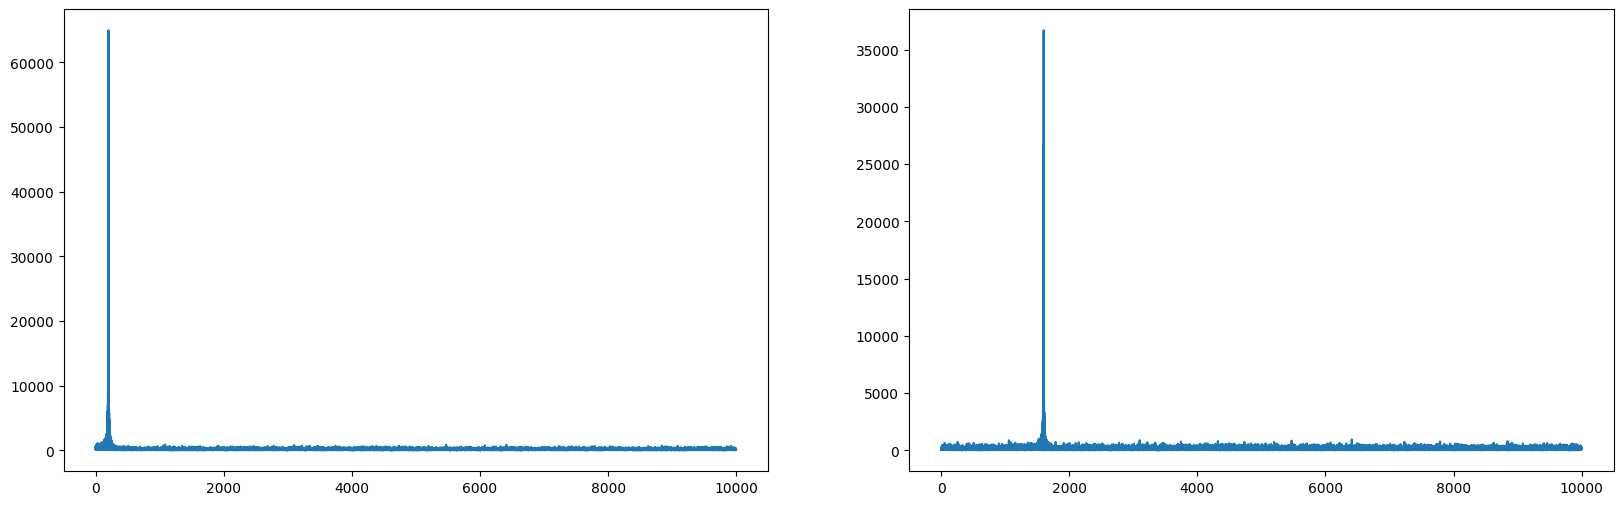

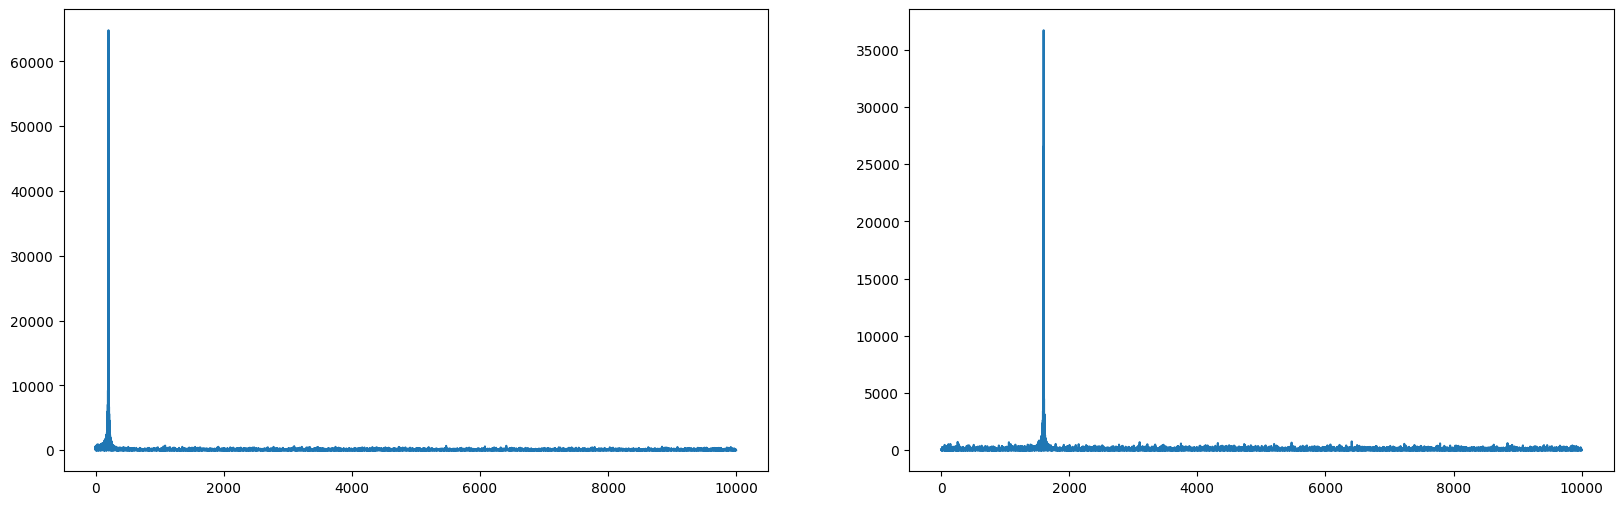

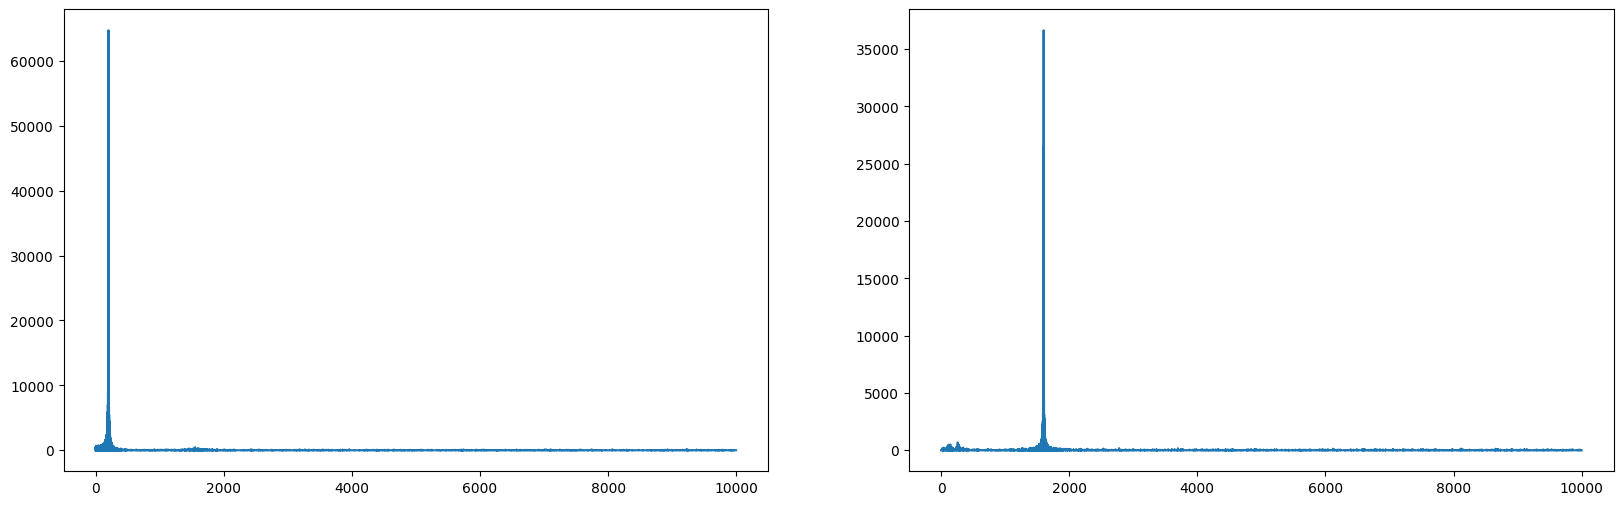

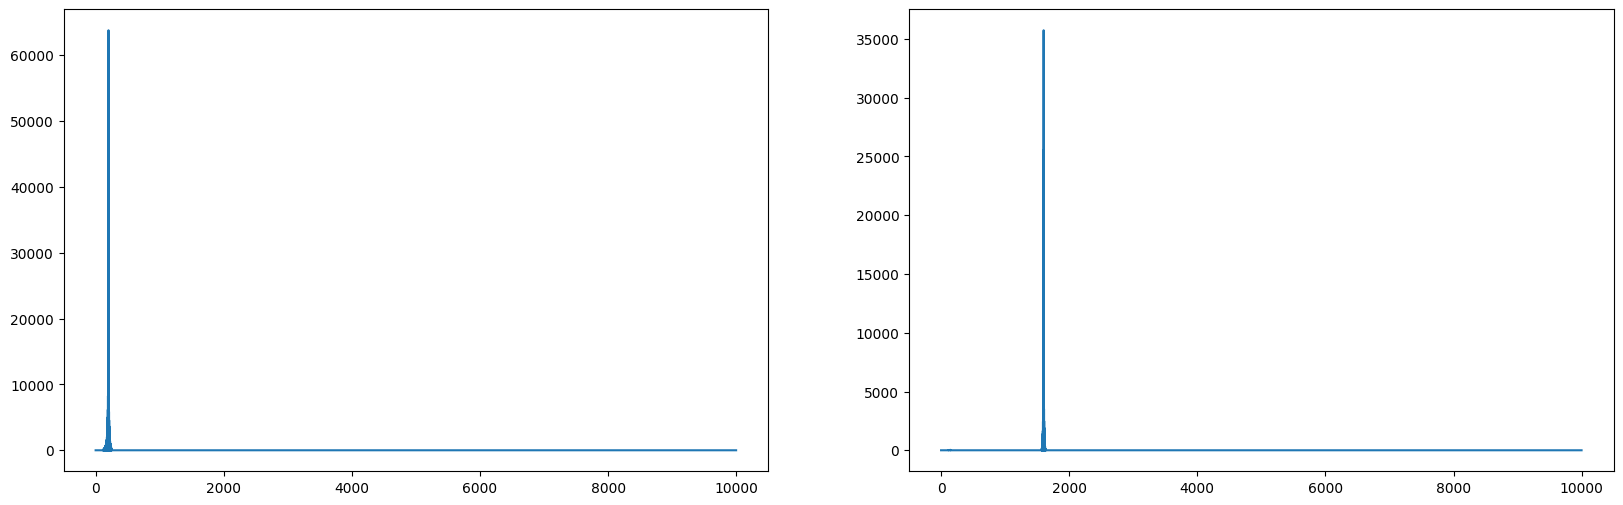

In [16]:
S_estf = np.zeros((4, Xf.shape[0], Xf.shape[1]))

fig = plt.figure(figsize=(20, 6))
i = 0

# Try various lamb values
for lamb in [0, 10, 100, 1000]:
    fig = plt.figure(figsize=(20, 6))
    
    # Saving the estimated sources for each lambda
    S_estf[i,:,:] = ISTA(Xf, A = A,  n = 2, lamb=lamb, nbIt = 1000)

    plt.subplot(1,2,1)
    plt.plot(abs(S_estf[i,0,:]))

    plt.subplot(1,2,2)
    plt.plot(abs(S_estf[i,1,:]))

    plt.show()

    i += 1

Plot the estimated sources in the DCT domain. What kind of sparsity to they exhibit? Why?

### Determining the Range for $\lambda$

1. **Lower Bound of $\lambda$ (where $\lambda = 0$ serves as a minimum benchmark):**
   - A very low $\lambda$ results in minimal regularization, leading to a solution akin to a standard least squares fit. This can produce a solution where $S$ is overly dense, potentially capturing noise as if it were signal, thereby overfitting the data. When $\lambda$ is extremely low or approaches zero, the model ignores sparsity, focusing purely on fidelity to the observed data.

2. **Upper Bound of $\lambda$ (with an empirical upper limit at $\lambda = 1000$):**
   - Conversely, setting $\lambda$ excessively high may force $S$ to become too sparse, nullifying too many of its components. This level of sparsity can result in underfitting, where critical aspects of the source signals are neglected, and the reconstructed sources might not adequately reflect the observed data. At extreme values, the model prioritizes minimizing the $L1$ norm of $S$ at the expense of losing important data characteristics.

These guidelines underscore the need for careful calibration of $\lambda$ to balance between underfitting and overfitting, ensuring that the model captures the essential sparsity of the data without losing accuracy.

Transform the sources back in the direct domain. Plot them. What do you see? Explain the differences with the original sources. Conclude.

<Figure size 2000x600 with 0 Axes>

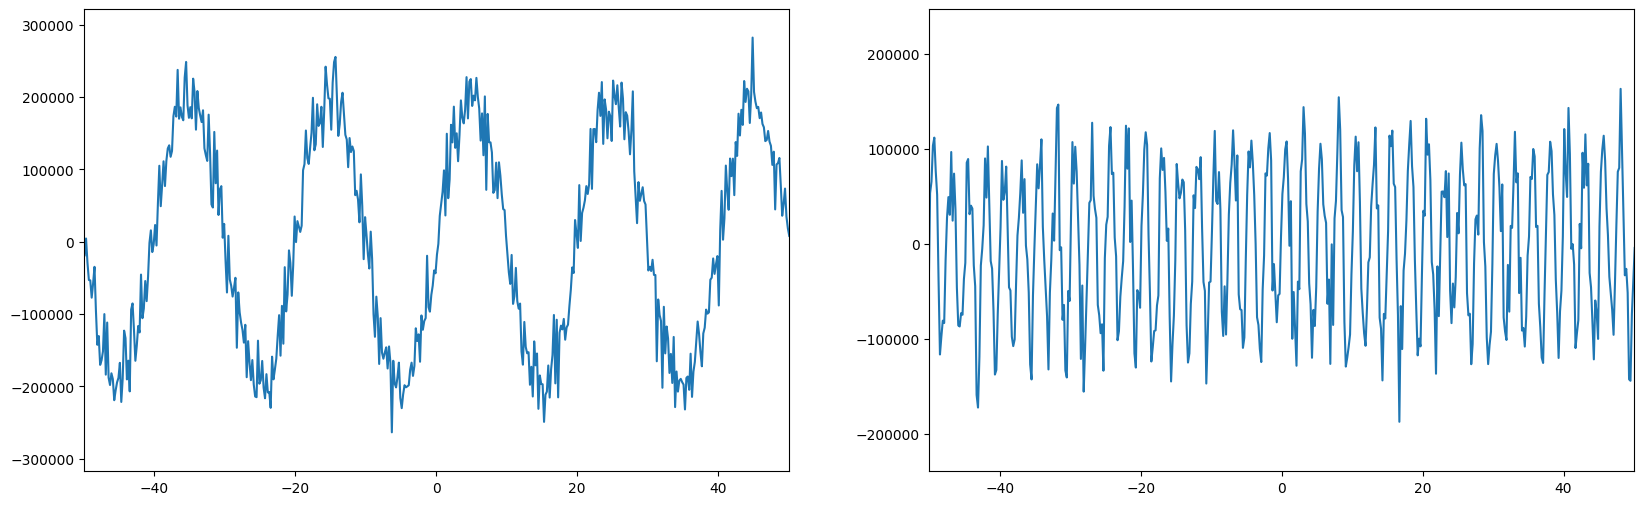

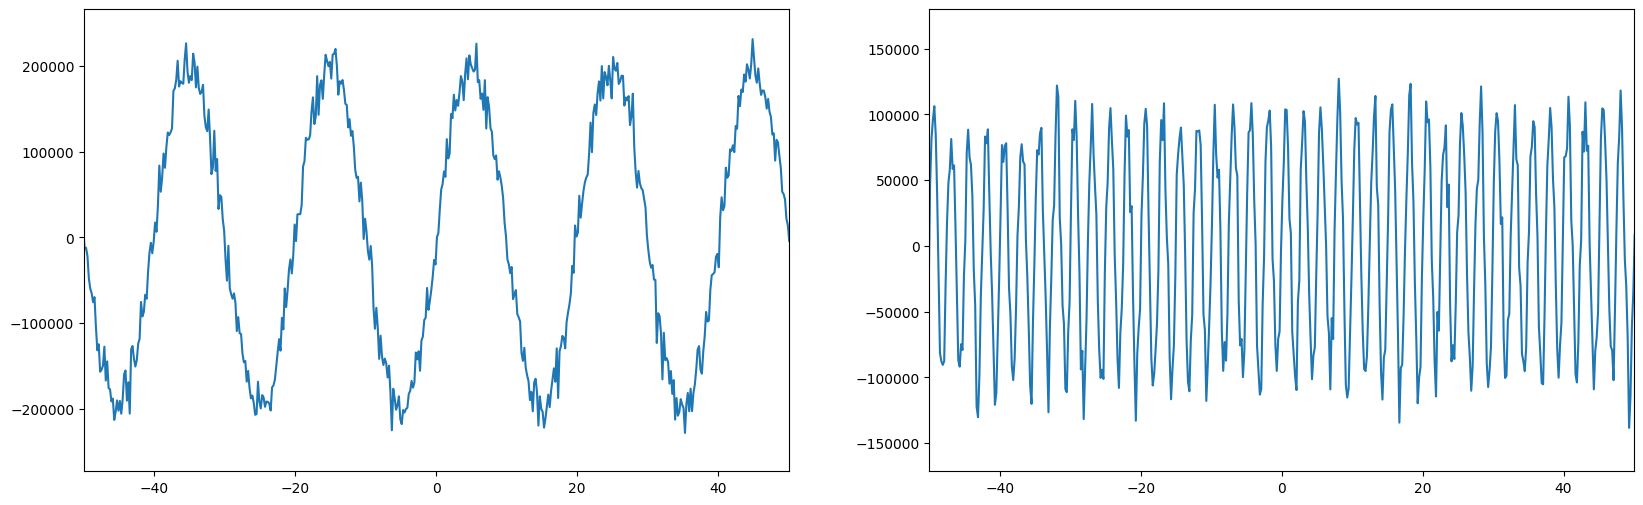

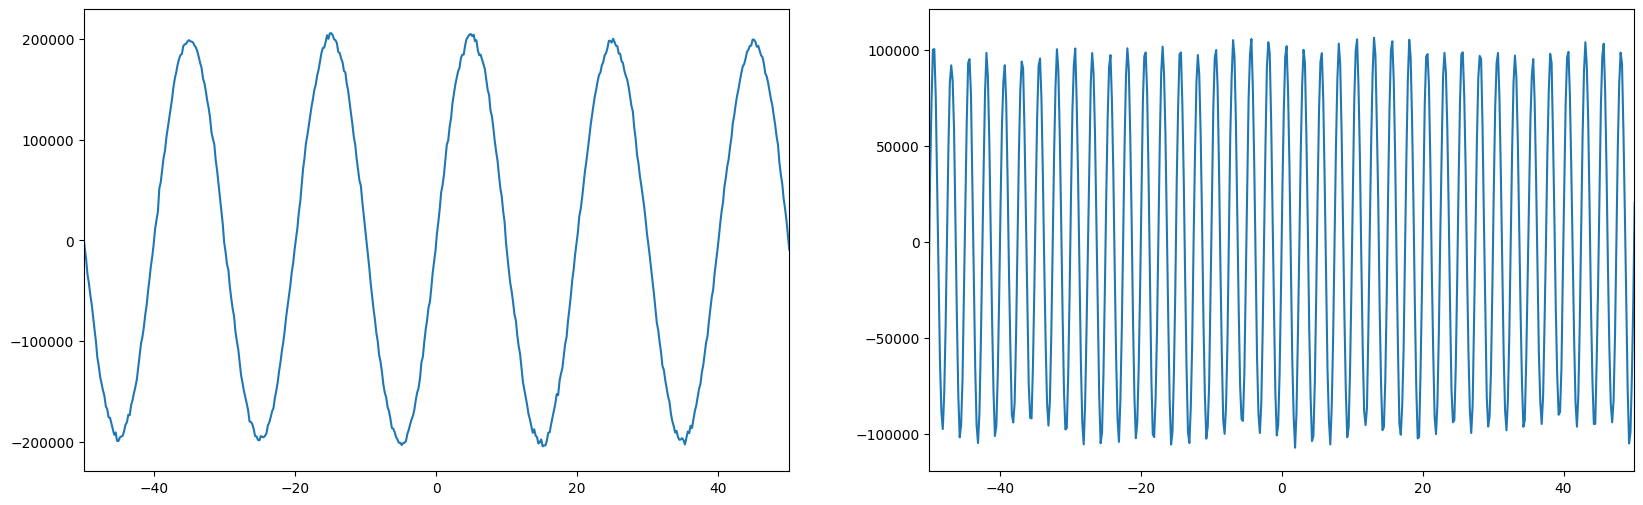

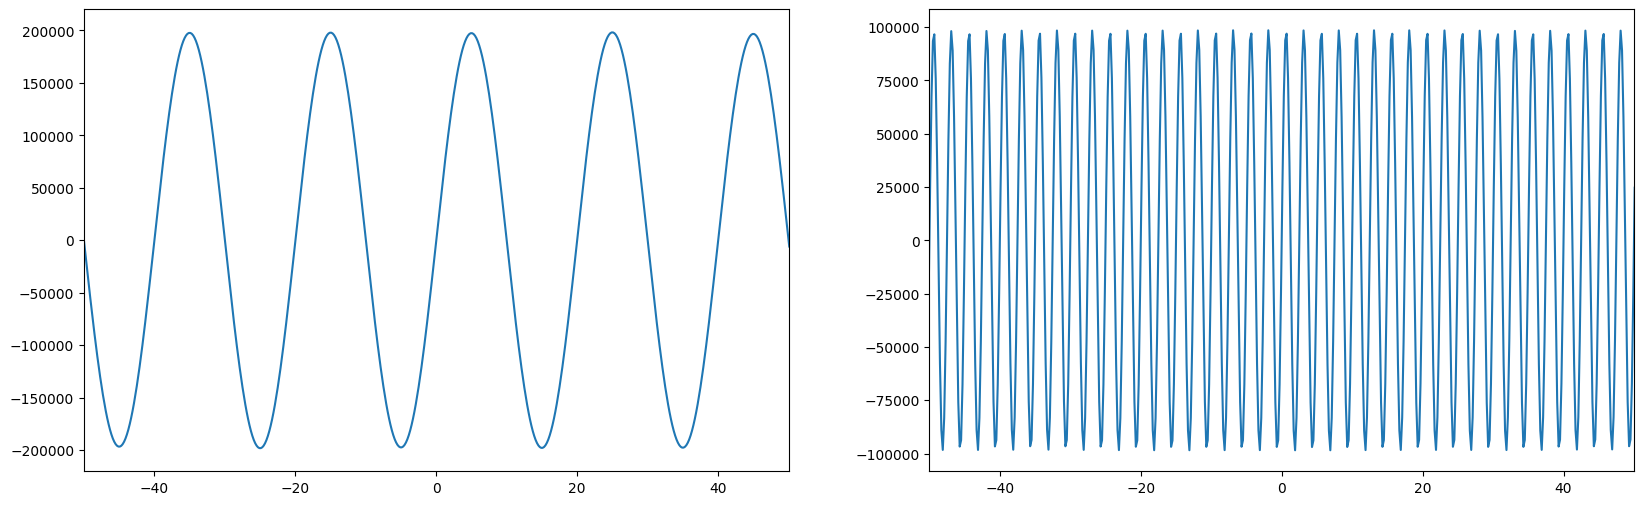

In [19]:
S_est = np.zeros((4, 2, X.shape[1]))

fig = plt.figure(figsize=(20, 6))

for i in range(4):

    fig = plt.figure(figsize=(20, 6))

    S_est[i,:,:] = sff.idct(S_estf[i,:,:])

    plt.subplot(1, 2, 1)
    plt.plot(x_abs, S_est[i, 0, :])
    plt.xlim(-50, 50)

    plt.subplot(1, 2, 2)
    plt.plot(x_abs, S_est[i, 1, :])
    plt.xlim(-50, 50)

### Effects of Varying $\lambda$ on Source Estimates

1. **High $\lambda$ (e.g., 1000):**
   - **Effect**: Using a high $\lambda$ can lead to overly sparse source estimates. This results in many components of the signal being eliminated, leaving only a few significant peaks.
   - **Consequence**: The sparsity driven by high $\lambda$ values compromises the fidelity to the original signals, although it excels at suppressing noise.

2. **Moderate $\lambda$ (e.g., 100 and 10):**
   - **Effect**: A moderate $\lambda$ strikes a more balanced approach, preserving more of the signal's structure while still promoting sparsity where beneficial.
   - **Consequence**: This balance allows for a more accurate reconstruction of the original sources and provides effective noise suppression without overly distorting the signal.

3. **Low $\lambda$ (e.g., 1):**
   - **Effect**: A low $\lambda$ minimally enforces sparsity, making the source estimates closely resemble those from a least squares solution. This approach retains most of the signal structure but does less to filter out noise.
   - **Consequence**: While the fidelity to the original signals is high, the potential for retaining noise is also increased.

Selecting the appropriate lambda value is crucial for effectively balancing fidelity to the original sources and noise suppression via sparsity enforcement. The optimal lambda depends on the specific characteristics of the signals and the prevailing noise levels. In practical scenarios, the choice of lambda should be guided by the desired level of sparsity and the acceptable degree of signal detail loss. 

**III - Blind Source Separation : PALM**

Let's now delve into the core problem : *blind* source separation, in which **A** is unknown. To leverage sparsity, we will use the PALM algorithm.

Thoughout this whole section, we will re-use the same synthetic data as above (i.e., the one generated in II-1).

Write the cost function we want to minimize to perform *blind* sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?

For blind sparse source separation, unlike the non-blind case, both the mixing matrix $A$ and the source signals $S$ are unknown and must be estimated from the observed data $X$. The cost function for blind sparse source separation often includes terms that promote both data fidelity and sparsity, and possibly additional constraints to ensure identifiability and stability of the solution.

### Cost Function for Blind Sparse Source Separation

$$ J(A, S) = \frac{1}{2} \| X - AS \|_F^2 + \lambda \| S \|_1 + \gamma g(A) $$

Where:
- $X$ is the observed data matrix.
- $A$ is the mixing matrix to be estimated.
- $S$ is the sources matrix to be estimated.
- $\| \cdot \|_F$ denotes the Frobenius norm, measuring the discrepancy between the observed data and the modeled data from the estimated sources and mixing matrix.
- $\| \cdot \|_1$ denotes the $L1$ norm, promoting sparsity in the sources.
- $\lambda$ and $\gamma$ are regularization parameters that balance the influence of their respective terms.
- $g(A)$ is a regularization term applied to the mixing matrix, which might enforce constraints such as orthogonality, normalization (e.g., each column of $A$ having unit norm), or other properties.

### Explanation of Each Term:

1. **Smooth Term - $\frac{1}{2} \| X - AS \|_F^2$**: This term is smooth with respect to both $A$ and $S$. It is a quadratic function and differentiable, representing the data fidelity term that ensures the estimated signals, when mixed by $A$, approximate the observed data $X$.

2. **Non-Smooth Term - $\lambda \| S \|_1$**: This term is non-smooth due to the $L1$ norm, which promotes sparsity in the sources $S$. The $L1$ norm is effective in making many elements of $S$ exactly zero, which is desirable in sparse source separation.

3. **Regularization Term - $\gamma g(A)$**: The nature of this term depends on the choice of $g(A)$. Common choices like imposing orthogonality or unit norm constraints are generally smooth but could introduce non-convexity depending on the specific function form.

### Convexity of the Cost Function:

- The overall convexity of the cost function $J(A, S)$ depends on the terms involved:
  - The term $\frac{1}{2} \| X - AS \|_F^2$ is convex in either $A$ or $S$ individually when the other is fixed, but it is not convex jointly in $A$ and $S$.
  - The $L1$ norm $\| S \|_1$ is convex.
  - The regularization term $\gamma g(A)$ may introduce non-convexity, depending on how $g(A)$ is defined.

Given the joint consideration of $A$ and $S$ in the quadratic term and the potential non-convexity of $g(A)$, the cost function $J(A, S)$ for blind sparse source separation is generally non-convex. 

Recall what the gradient of the data fidelity term over A is.

To compute the gradient of the data fidelity term with respect to the mixing matrix $A$ in the context of source separation, we look at the specific part of the cost function:

$$\frac{1}{2} \| X - AS \|_F^2$$

Here, $X$ is the matrix of observed data, $A$ is the mixing matrix, and $S$ is the matrix of sources. The goal is to find how changes in $A$ affect this fidelity term, which measures how well the product of $A$ and $S$ approximates $X$.

### Steps to Compute the Gradient:

1. **Express the Cost Function**:
   $$f(A) = \frac{1}{2} \| X - AS \|_F^2$$
   This can be expanded using the definition of the Frobenius norm:
   $$f(A) = \frac{1}{2} \text{tr}((X - AS)^\top (X - AS))$$
   Simplifying this expression using properties of trace and matrix multiplications gives:
   $$f(A) = \frac{1}{2} \text{tr}(X^\top X - X^\top AS - S^\top A^\top X + S^\top A^\top AS)$$

2. **Compute the Gradient**:
   Taking the derivative of $f(A)$ with respect to $A$, and remembering that the derivative of $\text{tr}(ABA^\top C)$ with respect to $A$ is $CAB + C^\top AB^\top$ (given certain conditions on matrix dimensions that match for multiplication), the derivative in this context where $B$ and $C$ effectively simplify to identity matrices through $S$ and $X$, we get:
   $$\nabla_A f(A) = -S (X - AS)^\top$$
   Here, we used that the gradient of $\text{tr}(S^\top A^\top X)$ is $XS^\top$, and the gradient of $\text{tr}(S^\top A^\top AS)$ is $AS S^\top$.

   Simplifying, the gradient of the data fidelity term is:
   $$\nabla_A f(A) = -S (X - AS)^\top + AS S^\top$$
   Simplified further considering matrix operations, this is often expressed as:
   $$\nabla_A f(A) = (AS - X) S^\top$$

Thus, the gradient of the data fidelity term $\frac{1}{2} \| X - AS \|_F^2$ with respect to $A$ is:
$$\nabla_A f(A) = (AS - X) S^\top$$
This gradient points in the direction of the steepest increase of the term $\frac{1}{2} \| X - AS \|_F^2$. When using gradient descent methods to minimize this term, $A$ is updated by moving against this gradient. This update helps adjust $A$ to better approximate $X$ through the product $AS$.

Compte the proximal operator of the oblique constraint. Implement it.

In [20]:
def prox_oblique(A):
   return A / np.linalg.norm(A, axis=0, keepdims=True)

Implement the PALM algorithm to minimize the cost function you wrote in III-1).

In [21]:
def PALM(X,n=2,lamb=0,nbIt = 100):
    m = X.shape[0]
    t = X.shape[1]
    A_est = np.random.randn(m,n)
    S_est = np.random.randn(n,t)

    L_A = np.linalg.norm(np.dot(S_est, S_est.T), 2)
    L_S = np.linalg.norm(np.dot(A_est.T, A_est), 2)

    for i in range(nbIt):
        # Update of A
        grad_A = np.dot(np.dot(A_est, S_est) - X, S_est.T)
        A_est = A_est - grad_A/L_A
        A_est = prox_oblique(A_est)

        # Update of S
        grad_S = np.dot(A_est.T, np.dot(A_est, S_est) - X)
        S_est = S_est - grad_S/L_S
        S_est = prox_l1(S_est, lamb/L_S)

    return A_est,S_est

Launch the PALM algorithm to retrieve both A and S from X. Plot your results. How good is the separation? The separation quality is usually well evaluated comparing the true and estimated A matrices.

C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\linalg\linalg.py:2582: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real


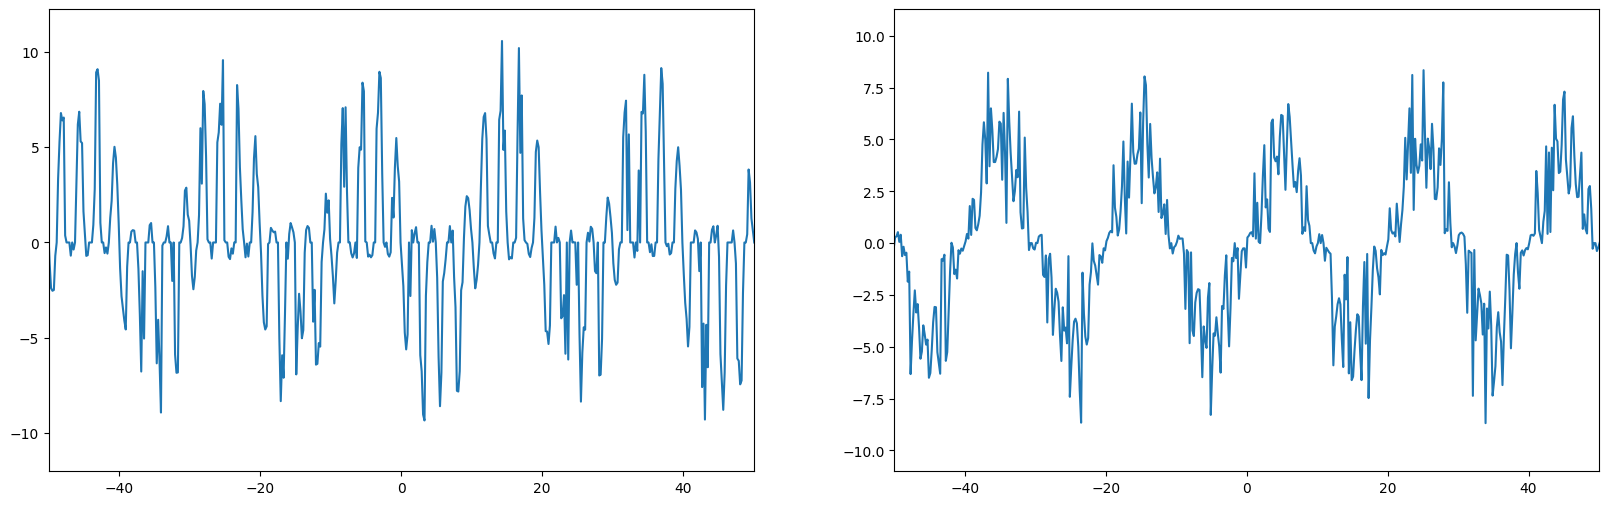

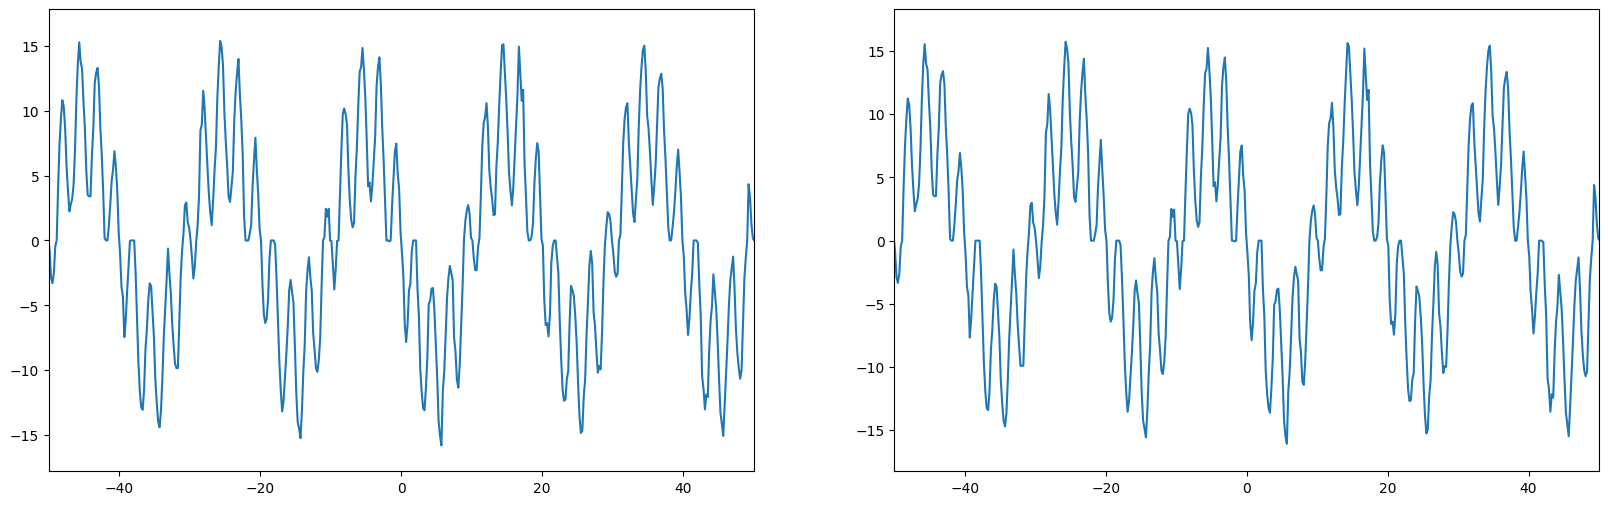

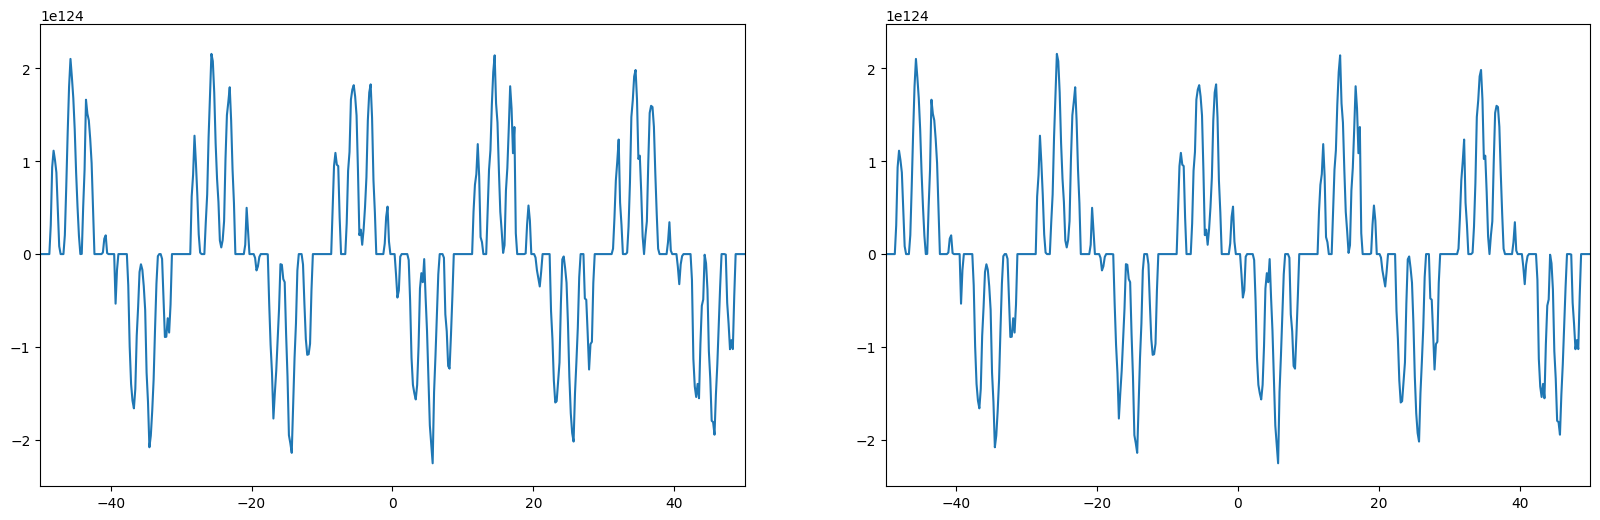

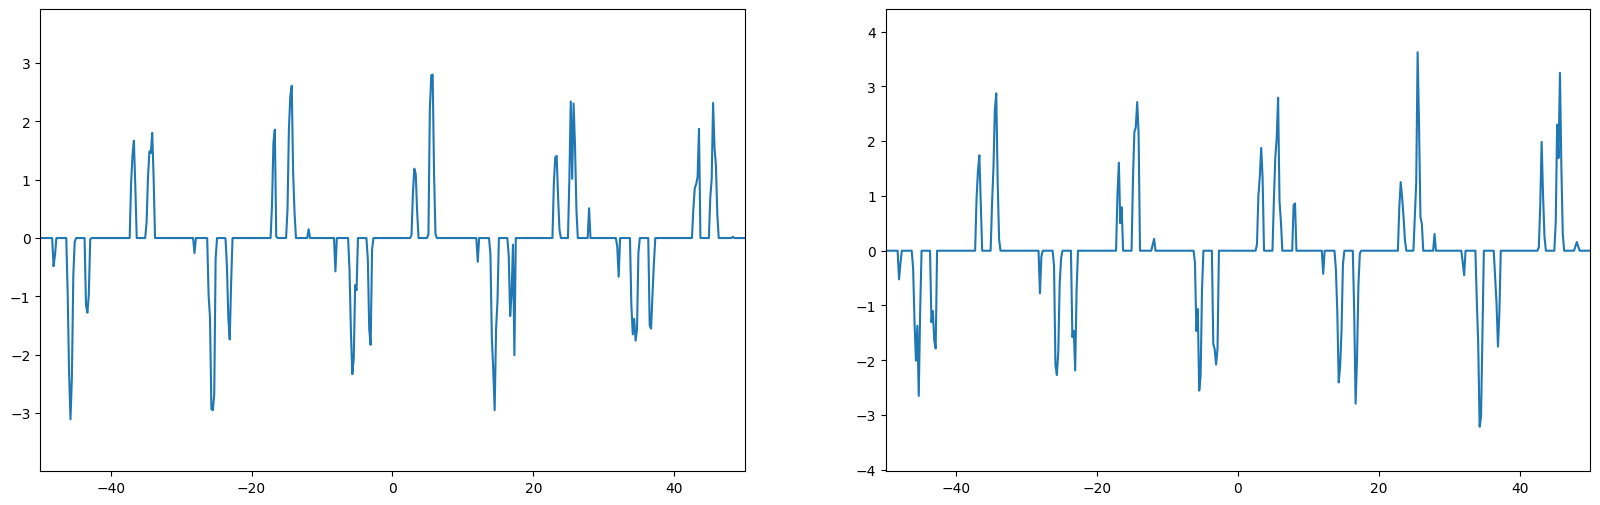

In [24]:
# PALM algorithm with different lamb values
A_est = []
S_est = []
for lamb in [0.1, 1, 5, 10]:
    A_est_temp, S_est_temp = PALM(X, n=2, lamb=lamb, nbIt=1000)
    A_est.append(A_est_temp)
    S_est.append(S_est_temp)

for i in range(4):
    fig = plt.figure(figsize=(20, 6))

    plt.subplot(1, 2, 1)
    plt.plot(x_abs, S_est[i][0, :])
    plt.xlim(-50, 50)

    plt.subplot(1, 2, 2)
    plt.plot(x_abs, S_est[i][1, :])
    plt.xlim(-50, 50)

### Observations from the Plots:

1. **High $\lambda$:**
   - The source estimates are notably sparse, characterized by a few non-zero entries. This pronounced sparsity arises from the strong $L1$-norm penalty in the cost function, which aggressively drives many elements of the source matrix $S$ to zero.
   - While this helps in reducing noise and extraneous variations, it may also lead to the suppression of essential signal components, potentially resulting in the loss of critical information.

2. **Moderate $\lambda$:**
   - The source estimates exhibit more detail than those obtained with a higher $\lambda$, yet remain fairly sparse. This suggests a more balanced approach, effectively preserving data integrity while still promoting sparsity.
   - This level of sparsity might be near the ideal, where significant signal details are maintained alongside effective noise reduction.

3. **Low $\lambda$:**
   - Lower values of $\lambda$ result in less pronounced sparsity enforcement, yielding source estimates that are richer in detail and more variable. The estimated signals more closely resemble the original complex waveforms.
   - At a $\lambda$ of 1, the effect of $L1$-norm regularization becomes nearly inconsequential, with the source estimates showing varied and detailed fluctuations. This indicates minimal sparsity, which may be suitable if the original sources are inherently non-sparse or if capturing detailed temporal dynamics is essential.

### Contrast Between PALM and ISTA:

- **Algorithmic Focus**: ISTA is generally applied in non-blind source separation scenarios where the mixing matrix $A$ is predefined and constant. This method optimally balances data fidelity against source sparsity, focusing updates exclusively on the source matrix $S$. Conversely, PALM is utilized in blind source separation contexts where both $A$ and $S$ are initially unknown, dynamically alternating updates between the two based on current estimates, which enhances its adaptability.

- **Approach to $A$ and $S$**: ISTA simplifies the optimization process by fixing $A$ and optimizing only for $S$, which narrows its applicability to situations with a known $A$. PALM, however, treats both $A$ and $S$ as variables to be optimized, thus engaging a more complex non-convex optimization challenge but increasing its utility across a broader range of scenarios with limited prior information.

- **Complexity and Utility**: ISTA offers a more straightforward and possibly quicker solution when $A$ is known, benefiting from a less complex problem structure. In contrast, PALM's ability to adjust both $A$ and $S$ introduces greater flexibility and complexity, necessitating meticulous parameter tuning and careful consideration of initialization and step sizes.

- **Promotion of Sparsity**: While both algorithms employ $L_1$ regularization to foster sparsity, the implementation and impact of this strategy are more sophisticated in PALM due to the simultaneous optimization of $A$ and $S$. In PALM, achieving the right balance of sparsity for both matrices can be intricate but rewarding, as it allows for the extraction of meaningful information from highly mixed data.